# Flood Prediction Model 1 - Hourly Discharge at Caboolture River

The Objective of this notebook is to create a flood prediction model for the Caboolture River at Upper Caboolture. We will use hourly rainfall data and an hourly discharge as the target time series and a single hourly rainfall time series as input variable. This model will be used for comparision with [RORB](https://www.monash.edu/engineering/departments/civil/research/themes/water/rorb)’s predictions.

## Benchmark Model

[RORB](https://www.monash.edu/engineering/departments/civil/research/themes/water/rorb) model is generally employed for calculating design flood discharges. It uses many assumptions and is manually calibrated to one flooding event. This will be used as benchmark model for comparison purpose.

## Data Set
The hydrological data available at [Queensland Water Monitoring Information Portal](https://water-monitoring.information.qld.gov.au/) will be used. Hourly as well as daily water flow data is available at various stations. Rainfall data is available in some of the stations. For the Caboolture River, only single discharge and rainfal station is available. 



### Work Workflow

* Preprocessing and exploring the data
* Creating training and test sets of time series
* Formatting data as JSON files and uploading to S3
* Instantiating and training a DeepAR estimator
* Deploying a model and creating a predictor
* Comparing the Predictor with RORB's performance

# Preprocessing and exploring the data

The raw data for Caboolture River is available at raw_data/Caboolture folder. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utility import unzip_ts_data, read_ts_data, series_to_json


In [2]:
# Read target (flow) and feature (rain) data

target_name = '142001A_20191103_flow' # folder name containing target time series

# Unzip the data and get list of csv paths
cabooltre_csv_paths = unzip_ts_data('./raw_data/Caboolture')
maroochy_csv_paths = unzip_ts_data('./raw_data/Maroochy')
brisbane_csv_paths = unzip_ts_data('./raw_data/Brisbane')

# Select the target csv
target_csv_paths = []
other_csv_paths = []
for csv_path in cabooltre_csv_paths:
    if target_name in csv_path:
        target_csv_paths.append(csv_path)
    else:
        other_csv_paths.append(csv_path)
        


./raw_data/Caboolture/142001A_20191103_rain
unzipped 142001A_20191103_rain.zip!
./raw_data/Caboolture/142001A_20191103_flow
unzipped 142001A_20191103_flow.zip!
./raw_data/Maroochy/141004B_20191110_rain
unzipped 141004B_20191110_rain.zip!
./raw_data/Brisbane/143306B_20191112
unzipped 143306B_20191112.zip!


In [3]:
cabooltre_csv_paths

['./raw_data/Caboolture/142001A_20191103_rain/142001A.csv',
 './raw_data/Caboolture/142001A_20191103_flow/142001A.csv']

In [4]:
# Read the extracted csv data

target_ts_data = read_ts_data(target_csv_paths[0], value_cols = ["Mean"], prefix = "CabFlow")

rain_ts_data = read_ts_data(other_csv_paths[0], value_cols = ["Total"], prefix = "CabRain")

rain_maroochy_ts_data = read_ts_data(maroochy_csv_paths[0], value_cols = ["Total"], prefix = "MarRain")
rain_brisbane_ts_data = read_ts_data(brisbane_csv_paths[0], value_cols = ["Total"], prefix = "BrisRain")


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [5]:
main_ts_data = target_ts_data.join(rain_ts_data)


## Missing Values

First we remove the missing values from the both ends of time. After doing so, we find that there are no missing values for the flow data while there are some missing data for the rainfall data. We replace the missing rainfall data with the rainfall from the nearest station in Maroochy basin.

In [6]:
def first_last_non_null(all_ts_data):
    """
    Returns the index for first and last non-null rows on data
    """
    selec_non_null = np.apply_along_axis(np.sum, 1, ~pd.isnull(all_ts_data).values) >= 2
    # Find the first and last non-null index for all data
    first_index = all_ts_data.index[selec_non_null][0]
    last_index = all_ts_data.index[selec_non_null][-1]

    return first_index, last_index

# Select for this period

first_index, last_index = first_last_non_null(main_ts_data)

selec_all_ts_data = main_ts_data.iloc[(main_ts_data.index >= first_index) & (main_ts_data.index <= last_index),]

selec_all_ts_data.describe()

,CabFlowMean,CabRainTotal
count,248640.000000,244332.000000
mean,0.939243,0.128908
std,8.070325,1.135370
min,0.000000,0.000000
25%,0.017500,0.000000
50%,0.074000,0.000000
75%,0.252000,0.000000
max,567.881600,87.000000


In [7]:
# Replace the missing rainfall with Maroochy rain

selec2_all_ts_data = selec_all_ts_data.join(rain_maroochy_ts_data)

selec2_all_ts_data.iloc[pd.isnull(selec2_all_ts_data.iloc[:,1]).values,1] = selec2_all_ts_data.iloc[pd.isnull(selec2_all_ts_data.iloc[:,1]).values,2]

selec2_all_ts_data.drop("MarRainTotal", 1, inplace = True)

In [8]:
selec2_all_ts_data.describe()

,CabFlowMean,CabRainTotal
count,248640.000000,248640.000000
mean,0.939243,0.129345
std,8.070325,1.138789
min,0.000000,0.000000
25%,0.017500,0.000000
50%,0.074000,0.000000
75%,0.252000,0.000000
max,567.881600,87.000000


<Figure size 1440x432 with 0 Axes>

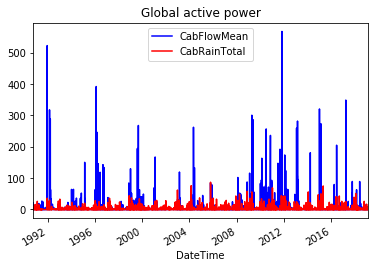

In [9]:
# Plot filter

# display the data 
plt.figure(figsize=(20,6))
# all data points
selec2_all_ts_data.plot(title='Global active power', color=['blue','red']) 
plt.show()

# Spliting to Training and Test Series
Now we split the data into training and test series. Data up to 2016 will be used for training and then the rest for testing.

In [11]:
train_all_ts_data = selec2_all_ts_data.iloc[selec2_all_ts_data.index < pd.Timestamp('2016-01-01 00:00:00'),:]
test_all_ts_data = selec2_all_ts_data.iloc[selec2_all_ts_data.index >= pd.Timestamp('2016-01-01 00:00:00'),:]

# Convert to JSON


In [15]:
test_all_ts_data.head()

,CabFlowMean,CabRainTotal
DateTime,,
2016-01-01 00:00:00,0.0285,0.0
2016-01-01 01:00:00,0.0280,0.0
2016-01-01 02:00:00,0.0262,0.0
2016-01-01 03:00:00,0.0255,0.0
2016-01-01 04:00:00,0.0260,0.0


In [16]:
target_col = "CabFlowMean"
test_all_ts_data[[target_col,target_col]].values.transpose()

array([[0.0285, 0.028 , 0.0262, ..., 0.009 , 0.009 , 0.009 ],
       [0.0285, 0.028 , 0.0262, ..., 0.009 , 0.009 , 0.009 ]])

In [17]:
test_all_ts_data.columns.values

array(['CabFlowMean', 'CabRainTotal'], dtype=object)

In [31]:
target_col = "CabFlowMean"
train_json = series_to_json(train_all_ts_data, target_col)

# Save Data Locally

In [20]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, target_col, filename): 
    with open(filename, 'wb') as f:
        json_line = json.dumps(series_to_json(time_series, target_col)) + '\n'
        json_line = json_line.encode('utf-8')
        f.write(json_line)
    print(filename + ' saved.')

In [21]:
# save this data to a local directory
data_dir = 'json_model1_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [22]:
# directories to save train/test data
train_path = os.path.join(data_dir, 'train.json')
test_path = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(train_all_ts_data, target_col, train_path)        
write_json_dataset(train_all_ts_data, target_col, test_path)

json_model1_data/train.json saved.
json_model1_data/test.json saved.


# Uploading data to S3



In [23]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [24]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

Upload training data to a location in S3, and save that location to train_path
Upload test data to a location in S3, and save that location to test_path

In [327]:
prefix='flood-prediction-model-1'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_s3_path  = sagemaker_session.upload_data(train_path, bucket=bucket, key_prefix=train_prefix)
test_s3_path   = sagemaker_session.upload_data(test_path,  bucket=bucket, key_prefix=test_prefix)

In [329]:
# check locations
print('Training data is stored in: '+ train_s3_path)
print('Test data is stored in: '+ test_s3_path)

Training data is stored in: s3://sagemaker-ap-southeast-2-990878777707/flood-prediction-model-1/train/train.json
Test data is stored in: s3://sagemaker-ap-southeast-2-990878777707/flood-prediction-model-1/test/test.json


---
# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [25]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


### Instantiate an Estimator 

You can now define the estimator that will launch the training job. A generic Estimator will be defined by the usual constructor arguments and an `image_name`. 
> You can take a look at the [estimator source code](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/estimator.py#L595) to view specifics.


In [337]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.2xlarge',
                      output_path=s3_output_path
                      )


## Setting Hyperparameters

Next, we need to define some DeepAR hyperparameters that define the model size and training behavior. Values for the epochs, frequency, prediction length, and context length are required.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

### Context Length

Typically, it is recommended that you start with a `context_length`=`prediction_length`. This is because a DeepAR model also receives "lagged" inputs from the target time series, which allow the model to capture long-term dependencies. For example, a daily time series can have yearly seasonality and DeepAR automatically includes a lag of one year. So, the context length can be shorter than a year, and the model will still be able to capture this seasonality. 

The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are the previous week, 2 weeks, 3 weeks, 4 weeks, and year. You can read more about this in the [DeepAR "how it works" documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html).

### Optional Hyperparameters

You can also configure optional hyperparameters to further tune your model. These include parameters like the number of layers in our RNN model, the number of cells per layer, the likelihood function, and the training options, such as batch size and learning rate. 

For an exhaustive list of all the different DeepAR hyperparameters you can refer to the DeepAR [hyperparameter documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

In [19]:
# freq='H' # Hourly
context_length = 24
prediction_length = 7

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [339]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training Job

Now, we are ready to launch the training job! SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the *actual* value of the time series. The computed error metrics will be included as part of the log output.

The next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [340]:
%%time
# train and test channels
data_channels = {
    "train": train_s3_path,
    "test": test_s3_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2019-11-21 07:41:20 Starting - Starting the training job...
2019-11-21 07:41:25 Starting - Launching requested ML instances......
2019-11-21 07:42:50 Starting - Preparing the instances for training......
2019-11-21 07:43:36 Downloading - Downloading input data...
2019-11-21 07:44:16 Training - Training image download completed. Training in progress..Arguments: train
[11/21/2019 07:44:18 INFO 140411496507200] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience':

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [ ]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

-----------------------------------------------------------------------------------------

## Create endpoint from job name

In [26]:
job_name = "forecasting-deepar-2019-11-21-07-41-20-349"

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

--------------------------------------------------------------------------------------------------------------------------!

In [34]:
def json_predictor_input(input_ts, target_col, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    
    instances.append(series_to_json(input_ts, target_col))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

In [23]:
test_all_ts_data.index[1] - test_all_ts_data.index[0]

Timedelta('0 days 01:00:00')

In [18]:
freq

NameError: name 'freq' is not defined

In [42]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)

target_col = "CabFlowMean"
predictor.set_prediction_parameters(freq, prediction_length, target_col)

In [43]:
json_prediction = predictor.predict(test_all_ts_data)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:


# get all input and target (test) time series
input_ts = test_all_ts_data

# get formatted input time series
json_input_ts = json_predictor_input(input_ts, target_col)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

#print(json_prediction)